In [1]:
!pip install torch torchvision

In [14]:
!pip install h5py


Using device: cpu
 Loading holdout dataset...
Extracting from: <class 'torch.utils.data.dataset.Subset'>
Extracted: X=torch.Size([2000, 1, 28, 28]), y=torch.Size([2000])
 Train: torch.Size([1600, 1, 28, 28]) (1600 samples)
 Test:  torch.Size([400, 1, 28, 28]) (400 samples)
 Saved: task2_plots/01_class_imbalance.png


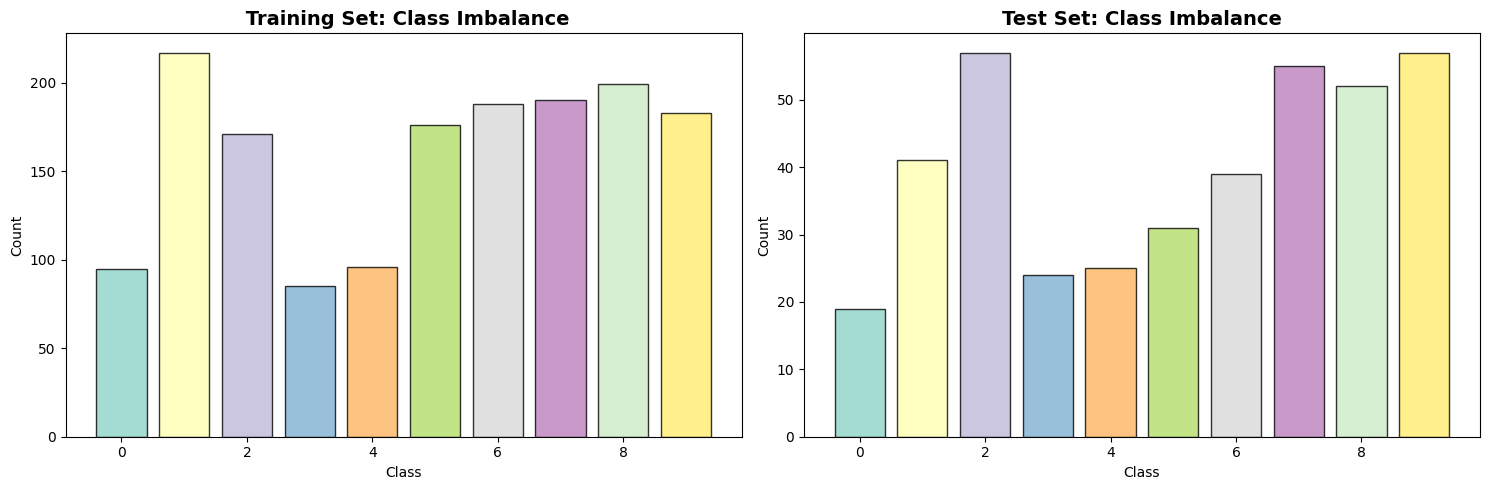


######################################################################
 TASK 2: CNN BIAS ANALYSIS

1. CNN WITHOUT BIAS MITIGATION
 NO BIAS MITIGATION: Standard loss
Epoch 5: Loss=0.135, Acc=93.5%
Epoch 10: Loss=0.050, Acc=94.8%
Epoch 15: Loss=0.026, Acc=96.0%

 CNN_No_Mitigation:
 Class  Support Accuracy
     0       19   100.0%
     1       41   100.0%
     2       57    91.2%
     3       24    79.2%
     4       25    96.0%
     5       31    96.8%
     6       39   100.0%
     7       55    98.2%
     8       52    98.1%
     9       57    96.5%
SUMMARY: Overall=95.6% | Bias(Std)=0.060
 H5 weights saved: task2_weights/cnn_no_mitigation.h5

2. CNN WITH BIAS MITIGATION
 BIAS MITIGATION: Class-weighted loss
Epoch 5: Loss=0.169, Acc=93.0%
Epoch 10: Loss=0.054, Acc=94.8%
Epoch 15: Loss=0.040, Acc=94.8%

 CNN_Weighted:
 Class  Support Accuracy
     0       19   100.0%
     1       41   100.0%
     2       57    89.5%
     3       24    79.2%
     4       25   100.0%
     5       31   10

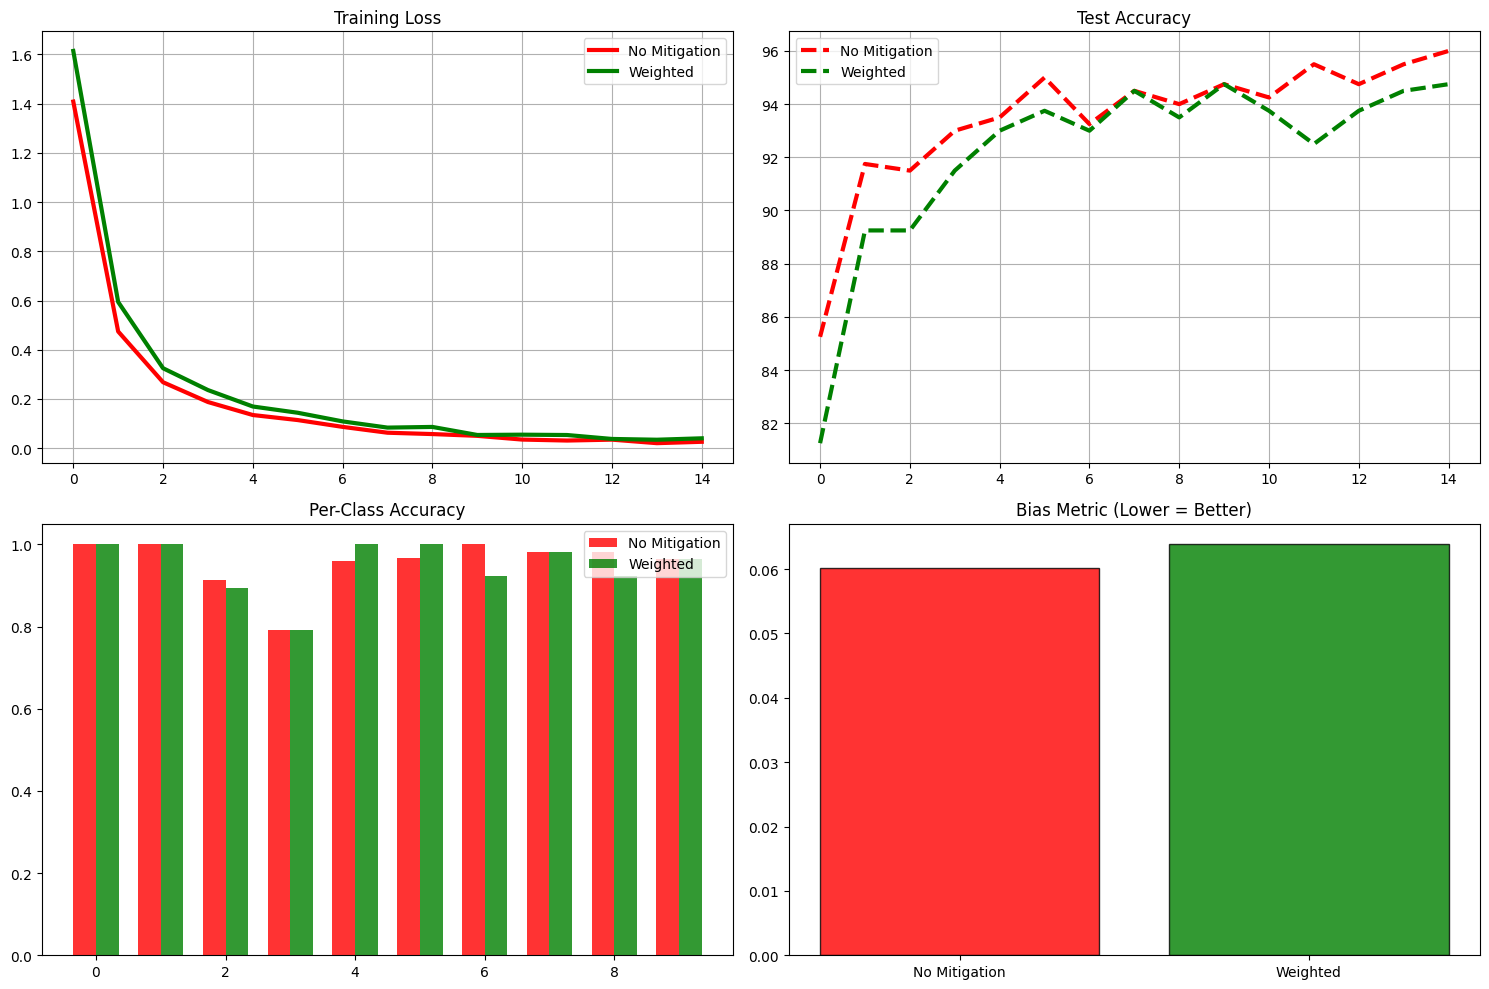

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
import h5py
import os
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load holdout dataset
print(" Loading holdout dataset...")
torch.serialization.add_safe_globals([torch.utils.data.dataset.Subset])
holdout_data = torch.load('/content/holdout_dataset.pt', weights_only=False, map_location='cpu')


########################### DATASET EXTRACTION ######################

def get_dataset_tensors(dataset):

    print(f"Extracting from: {type(dataset)}")

    if hasattr(dataset, 'dataset') and hasattr(dataset, 'indices'):
        base = dataset.dataset
        if hasattr(base, 'tensors') and len(base.tensors) >= 2:
            X_full, y_full = base.tensors[0], base.tensors[1]
            indices = dataset.indices
            X = X_full[indices].to('cpu')
            y = y_full[indices].to('cpu')
            return X, y


    X_list, y_list = [], []
    for i in range(min(2000, len(dataset))):
        try:
            item = dataset[i]
            if isinstance(item, (tuple, list)) and len(item) >= 2:
                x_item = torch.tensor(item[0]) if not torch.is_tensor(item[0]) else item[0]
                y_item = torch.tensor(item[1]) if not torch.is_tensor(item[1]) else item[1]
                X_list.append(x_item)
                y_list.append(y_item)
        except:
            continue

    if len(X_list) == 0:
        raise ValueError("No valid data extracted")

    X = torch.stack(X_list)
    y = torch.stack(y_list)
    print(f"Extracted: X={X.shape}, y={y.shape}")
    return X, y

# Extract data
X_full, y_full = get_dataset_tensors(holdout_data)
n_train = int(0.8 * len(X_full))
X_train, X_test = X_full[:n_train], X_full[n_train:]
y_train, y_test = y_full[:n_train], y_full[n_train:]

# Fix shapes
if len(X_train.shape) == 3: X_train = X_train.unsqueeze(1)
if len(X_test.shape) == 3: X_test = X_test.unsqueeze(1)

print(f" Train: {X_train.shape} ({len(y_train)} samples)")
print(f" Test:  {X_test.shape} ({len(y_test)} samples)")

# Data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create directories
os.makedirs('task2_plots', exist_ok=True)
os.makedirs('task2_weights', exist_ok=True)


########################## SAVE PLOTS FUNCTION ###############################

def save_plot(fig, filename):
    fig.savefig(f'task2_plots/{filename}', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    print(f" Saved: task2_plots/{filename}")


############################## CNN MODEL #####################################

class SimpleCNN(nn.Module):
    def __init__(self, name="CNN"):
        super(SimpleCNN, self).__init__()  # FIXED: proper super() call
        self.name = name
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):  # FIXED: explicit forward method
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # FIXED: proper flattening
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def save_h5_weights(self, filename):

        with h5py.File(filename, 'w') as f:
            f.attrs['model_type'] = self.name
            f.attrs['input_shape'] = [1, 28, 28]
            f.attrs['num_classes'] = 10

            f.create_dataset('conv1_weight', data=self.conv1.weight.data.cpu().numpy())
            f.create_dataset('conv1_bias', data=self.conv1.bias.data.cpu().numpy())
            f.create_dataset('conv2_weight', data=self.conv2.weight.data.cpu().numpy())
            f.create_dataset('conv2_bias', data=self.conv2.bias.data.cpu().numpy())
            f.create_dataset('fc1_weight', data=self.fc1.weight.data.cpu().numpy())
            f.create_dataset('fc1_bias', data=self.fc1.bias.data.cpu().numpy())
            f.create_dataset('fc2_weight', data=self.fc2.weight.data.cpu().numpy())
            f.create_dataset('fc2_bias', data=self.fc2.bias.data.cpu().numpy())

        print(f" H5 weights saved: {filename}")


######################### BIAS ANALYSIS #####################################

def analyze_bias_visual(y_train, y_test):
    train_counts = Counter(y_train.numpy())
    test_counts = Counter(y_test.numpy())

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    classes = range(10)
    colors = plt.cm.Set3(np.linspace(0, 1, 10))

    axes[0].bar(classes, [train_counts.get(i, 0) for i in classes],
                color=colors, alpha=0.8, edgecolor='black')
    axes[0].set_title(' Training Set: Class Imbalance', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Class'); axes[0].set_ylabel('Count')

    axes[1].bar(classes, [test_counts.get(i, 0) for i in classes],
                color=colors, alpha=0.8, edgecolor='black')
    axes[1].set_title('Test Set: Class Imbalance', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Class'); axes[1].set_ylabel('Count')

    plt.tight_layout()
    save_plot(fig, '01_class_imbalance.png')
    plt.show()

    return train_counts

train_counts = analyze_bias_visual(y_train, y_test)

######################### TRAINING & EVALUATION FUNCTIONS #########################

def train_model(model, train_loader, test_loader, use_weighting=False, epochs=15):
    model.to(device)

    if use_weighting:
        class_counts = np.bincount(y_train.numpy(), minlength=10)
        weights = 1. / (class_counts + 1e-6)
        weights = torch.FloatTensor(weights).to(device)
        criterion = nn.CrossEntropyLoss(weight=weights)
        print(" BIAS MITIGATION: Class-weighted loss")
    else:
        criterion = nn.CrossEntropyLoss()
        print(" NO BIAS MITIGATION: Standard loss")

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses, accs = [], []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(1)
                total += target.size(0)
                correct += (pred == target).sum().item()

        acc = 100 * correct / total
        losses.append(total_loss / len(train_loader))
        accs.append(acc)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}: Loss={losses[-1]:.3f}, Acc={acc:.1f}%")

    return losses, accs

def evaluate_bias_detailed(model, test_loader, name="Model"):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(1)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    class_accs, class_support = [], []
    for i in range(10):
        mask = all_targets == i
        support = mask.sum()
        class_support.append(int(support))
        if support > 0:
            acc = (all_preds[mask] == i).mean()
            class_accs.append(acc)
        else:
            class_accs.append(0)

    overall_acc = np.mean(class_accs)
    bias_std = np.std(class_accs)

    results_df = pd.DataFrame({
        'Class': range(10),
        'Support': class_support,
        'Accuracy': [f"{acc*100:.1f}%" for acc in class_accs]
    })

    print(f"\n {name}:")
    print(results_df.to_string(index=False))
    print(f"SUMMARY: Overall={overall_acc*100:.1f}% | Bias(Std)={bias_std:.3f}")

    results_df.to_csv(f'task2_plots/{name.replace(" ", "_").replace("(", "").replace(")", "")}_results.csv', index=False)

    return overall_acc, bias_std, class_accs, class_support, results_df


############################ EXECUTE TRAINING ################################

print("\n" + "#"*70)
print(" TASK 2: CNN BIAS ANALYSIS")


# 1. NO BIAS MITIGATION
print("\n1. CNN WITHOUT BIAS MITIGATION")
cnn_no_weight = SimpleCNN("CNN_NoMitigation")
cnn_no_losses, cnn_no_accs = train_model(cnn_no_weight, train_loader, test_loader, use_weighting=False)
no_acc, no_bias, no_class_accs, no_support, no_df = evaluate_bias_detailed(cnn_no_weight, test_loader, "CNN_No_Mitigation")


cnn_no_weight.save_h5_weights('task2_weights/cnn_no_mitigation.h5')
torch.save(cnn_no_weight.state_dict(), 'task2_weights/cnn_no_mitigation.pth')

# 2. WITH BIAS MITIGATION
print("\n2. CNN WITH BIAS MITIGATION")
cnn_weighted = SimpleCNN("CNN_Weighted")
cnn_w_losses, cnn_w_accs = train_model(cnn_weighted, train_loader, test_loader, use_weighting=True)
w_acc, w_bias, w_class_accs, w_support, w_df = evaluate_bias_detailed(cnn_weighted, test_loader, "CNN_Weighted")


cnn_weighted.save_h5_weights('task2_weights/cnn_bias_mitigated.h5')
torch.save(cnn_weighted.state_dict(), 'task2_weights/cnn_bias_mitigated.pth')


############################### FINAL COMPARISON PLOT ##########################

print("\n FINAL COMPARISON")
comparison = pd.DataFrame({
    'Model': ['No Mitigation', 'Weighted'],
    'Accuracy (%)': [f"{no_acc*100:.1f}", f"{w_acc*100:.1f}"],
    'Bias (Std)': [f"{no_bias:.3f}", f"{w_bias:.3f}"]
})
print(comparison)
comparison.to_csv('task2_plots/final_comparison.csv')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0,0].plot(cnn_no_losses, 'r-', linewidth=3, label='No Mitigation')
axes[0,0].plot(cnn_w_losses, 'g-', linewidth=3, label='Weighted')
axes[0,0].set_title('Training Loss'); axes[0,0].legend(); axes[0,0].grid(True)

axes[0,1].plot(cnn_no_accs, 'r--', linewidth=3, label='No Mitigation')
axes[0,1].plot(cnn_w_accs, 'g--', linewidth=3, label='Weighted')
axes[0,1].set_title('Test Accuracy'); axes[0,1].legend(); axes[0,1].grid(True)

x = np.arange(10)
width = 0.35
axes[1,0].bar(x - width/2, no_class_accs, width, label='No Mitigation', alpha=0.8, color='red')
axes[1,0].bar(x + width/2, w_class_accs, width, label='Weighted', alpha=0.8, color='green')
axes[1,0].set_title('Per-Class Accuracy'); axes[1,0].legend()

axes[1,1].bar(['No Mitigation', 'Weighted'], [no_bias, w_bias],
              color=['red', 'green'], alpha=0.8, edgecolor='black')
axes[1,1].set_title('Bias Metric (Lower = Better)')

plt.tight_layout()
save_plot(fig, '03_final_comparison.png')
plt.show()

